In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from pprint import pprint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys
import re
sys.path.append("../")
from gpusims.config import Config, parse_configs
from gpusims.bench import parse_benchmarks
from gpusims.run import SIMULATORS
import gpusims.native
import gpusims.accelsim

In [2]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [3]:
root_dir = Path("/Users/roman/dev/gpgpusims")
benchmark_dir = root_dir / "benchmarks"
run_dir = root_dir / "run"

In [4]:
assert benchmark_dir.is_dir()
configs = parse_configs(benchmark_dir / "configs" / "configs.yml")
pprint(configs)
benchmarks = parse_benchmarks(benchmark_dir / "benchmarks.yml")
pprint(benchmarks)

{'sm6_gtx1080': Config(/Users/roman/dev/gpgpusims/benchmarks/configs/SM6_GTX1080)}
{'matrixmul': Benchmark(/Users/roman/dev/gpgpusims/benchmarks/matrixMul),
 'matrixmul-modified': Benchmark(/Users/roman/dev/gpgpusims/benchmarks/matrixMul-modified)}


In [5]:
# start with a single benchmark and config
benchmark = benchmarks["matrixmul-modified"]
# benchmark = benchmarks["matrixmul"]
config = configs["sm6_gtx1080"]

simulators = SIMULATORS

## Hardware

In [6]:
def build_hw_kernel_df(csv_files):
    hw_kernel_df = pd.concat([pd.read_csv(csv) for csv in csv_files], ignore_index=False)
    # print(hw_kernel_df)
    # remove the units
    hw_kernel_df = hw_kernel_df[~hw_kernel_df["Correlation_ID"].isnull()]
    # remove memcopies
    hw_kernel_df = hw_kernel_df[~hw_kernel_df["Name"].str.contains(r"\[CUDA memcpy .*\]")]
    # name refers to kernels now
    hw_kernel_df = hw_kernel_df.rename(columns={"Name": "Kernel"})
    # remove columns that are only relevant for memcopies
    # df = df.loc[:,df.notna().any(axis=0)]
    hw_kernel_df = hw_kernel_df.drop(columns=["Size", "Throughput", "SrcMemType", "DstMemType"])
    # set the correct dtypes
    hw_kernel_df = hw_kernel_df.astype({
        "Start": "float64",
        "Duration": "float64",
        "Static SMem": "float64",
        "Dynamic SMem": "float64",
        "Device": "string",
        "Kernel": "string",
    })
    # print(hw_kernel_df.dtypes)
    # print(hw_kernel_df.shape)
    return hw_kernel_df

In [7]:
def build_hw_cycles_df(csv_files):
    hw_cycle_df = pd.concat([pd.read_csv(csv) for csv in csv_files], ignore_index=False)
    # print(hw_cycle_df)
    # remove the units
    hw_cycle_df = hw_cycle_df[~hw_cycle_df["Correlation_ID"].isnull()]
    # print(hw_cycle_df.shape)
    return hw_cycle_df

In [8]:
native_config = Config(name="nvidia_geforce_gtx_1080", path=None)
bench_config = gpusims.native.NativeBenchmarkConfig(
    run_dir=run_dir / "native",
    benchmark=benchmark,
    config=native_config,
)
print(bench_config)
print(bench_config.path)
assert bench_config.path.is_dir()

NativeBenchmarkConfig(Benchmark(/Users/roman/dev/gpgpusims/benchmarks/matrixMul-modified), Config(None))
/Users/roman/dev/gpgpusims/run/native/matrixmul-modified/nvidia_geforce_gtx_1080


In [9]:
def build_hw_df(kernel_csv_files, cycle_csv_files):
    kernel_df = build_hw_kernel_df(kernel_csv_files)
    print("kernels shape", kernel_df.shape)
    cycle_df = build_hw_cycles_df(cycle_csv_files)
    print("cycles shape", cycle_df.shape)
    
    # join them
    pprint(set(kernel_df.columns.to_list()).intersection(set(cycle_df.columns.to_list())))
    inner_hw_df = pd.merge(kernel_df, cycle_df, how="inner", on=["Stream", "Context", "Device", "Kernel"])
    print("inner merge shape", inner_hw_df.shape)
    
    # assert no nan values
    assert inner_hw_df.isna().any().sum() == 0
    return inner_hw_df

In [10]:
hw_df = build_hw_df(
    cycle_csv_files=list((bench_config.path / "results").rglob("*cycles.csv")),
    kernel_csv_files=list((bench_config.path / "results").rglob("result.csv")),
)
# all_hw_metrics = sorted(hw_df.columns.tolist())
# pprint(all_hw_metrics)
# pprint([m for m in all_hw_metrics if "cycle" in m.lower()])
# print(hw_df.shape)
# print(hw_df[[c for c in hw_df.columns if "hit" in c]])
hw_df.T

kernels shape (1, 16)
cycles shape (1, 168)
{'Stream', 'Kernel', 'Context', 'Device', 'Correlation_ID'}
inner merge shape (1, 180)


,0
Start,335252.544
Duration,4.672
Grid X,1.0
Grid Y,1.0
Grid Z,1.0
Block X,32.0
Block Y,32.0
Block Z,1.0
Registers Per Thread,30.0
Static SMem,8.0


## Accelsim

In [11]:
accel_config = gpusims.accelsim.AccelSimBenchmarkConfig(
    run_dir=run_dir / "accelsim",
    benchmark=benchmark,
    config=config,
)
print(accel_config)
print(accel_config.path)
assert accel_config.path.is_dir()

AccelSimBenchmarkConfig(Benchmark(/Users/roman/dev/gpgpusims/benchmarks/matrixMul-modified), Config(/Users/roman/dev/gpgpusims/benchmarks/configs/SM6_GTX1080))
/Users/roman/dev/gpgpusims/run/accelsim/matrixmul-modified/sm6_gtx1080


In [12]:
accel_df = pd.read_csv(accel_config.path / "results/stats.csv")
print("accel shape", accel_df.shape)
accel_df = accel_df.pivot(index=["kernel", "kernel_id"], columns=["stat"])["value"]
print("accel shape", accel_df.shape)
# pprint(accel_df.columns.tolist())
accel_df.T

accel shape (20, 4)
accel shape (1, 20)


kernel,final_kernel
kernel_id,0
stat,
gpgpu_n_tot_w_icount,4992.0000
gpgpu_silicon_slowdown,295314.0000
gpgpu_simulation_rate,5015.0000
gpgpu_simulation_time_sec,1.0000
gpu_ipc,31.4449
gpu_occupancy,49.5041
gpu_tot_ipc,31.4449
gpu_tot_sim_cycle,5015.0000


## Tejas

In [13]:
tejas_config = gpusims.tejas.TejasBenchmarkConfig(
    run_dir=run_dir / "tejas",
    benchmark=benchmark,
    config=config,
)
print(tejas_config)
print(tejas_config.path)
assert tejas_config.path.is_dir()

TejasBenchmarkConfig(Benchmark(/Users/roman/dev/gpgpusims/benchmarks/matrixMul-modified), Config(/Users/roman/dev/gpgpusims/benchmarks/configs/SM6_GTX1080))
/Users/roman/dev/gpgpusims/run/tejas/matrixmul-modified/sm6_gtx1080


In [14]:
tejas_df = pd.read_csv(tejas_config.path / "results/stats.csv")
print("tejas shape", tejas_df.shape)
# tejas_df = tejas_df.pivot(index=["kernel", "kernel_id"], columns=["stat"])["value"]
# print("accel shape", tejas_df.shape)
tejas_df.T

tejas shape (1, 7)


,0
emulator_type,OCELOT
created,NaN
sim_time_secs,0.886
total_inst_count,162
total_cycle_count,1404
kips,0.182844
total_ipc,0.115385


## Multi2Sim

In [15]:
m2s_config = gpusims.multi2sim.Multi2SimBenchmarkConfig(
    run_dir=run_dir / "m2s",
    benchmark=benchmark,
    config=config,
)
print(m2s_config)
print(m2s_config.path)
assert m2s_config.path.is_dir()
with open(m2s_config.path / "results/log.txt") as f:
    print(f.read())

Multi2SimBenchmarkConfig(Benchmark(/Users/roman/dev/gpgpusims/benchmarks/matrixMul-modified), Config(/Users/roman/dev/gpgpusims/benchmarks/configs/SM6_GTX1080))
/Users/roman/dev/gpgpusims/run/m2s/matrixmul-modified/sm6_gtx1080

; Multi2Sim 5.0 - A Simulation Framework for CPU-GPU Heterogeneous Computing
; Please use command 'm2s --help' for a list of command-line options.
; Simulation alpha-numeric ID: 88M8t


;
; Simulation Statistics Summary
;

[ General ]
RealTime = 1.10 [s]
SimEnd = ContextsFinished
SimTime = 47944.00 [ns]
Frequency = 1000 [MHz]
Cycles = 47945

[ Kepler ]
TotalInstructions = 893952
IntegerInstructions = 366592
FP32Instructions = 65536
FP64Instructions = 0
ControlInstructions = 73728
LSInstructions = 75776
MovementInstructions = 156672
ConversionInstructions = 0
PredicateInstructions = 35840
MiscInstructions = 119808

[ x86 ]
RealTime = 1.04 [s]
Instructions = 2977949
InstructionsPerSecond = 2851906




In [16]:
m2s_df = pd.read_csv(m2s_config.path / "results/stats.csv")
print("m2s shape", m2s_df.shape)
# all_metrics = m2s_df["Section"] + m2s_df["Stat"]
# all_metrics = sorted(all_metrics.unique().tolist())
# pprint(all_metrics)

# cycles = m2s_df[m2s_df["Stat"] == "Cycles"]
# cycles = cycles[cycles["Section"].str.contains("SM")]
# total_cycles = cycles["Value"].sum()
# print(cycles)
# print(total_cycles)

per_sm_metrics = m2s_df[m2s_df["Section"].str.match(r"SM \d+")]
per_sm_total = per_sm_metrics.groupby("Stat").sum(numeric_only=True).reset_index()
per_sm_total["Section"] = "Total"
assert(len(per_sm_total) == len(per_sm_metrics["Stat"].unique()))

m2s_df = pd.concat([m2s_df, per_sm_total])

m2s_df["Stat"] = m2s_df["Section"] + "." + m2s_df["Stat"]
del m2s_df["Section"]

m2s_df = m2s_df.set_index("Stat")
m2s_df = m2s_df.T
# m2s_df["Total.SMCount"] = len(per_sm_total)
# assert m2s_df["Total.SMCount"][0] == m2s_df["Config.Device.NumSM"][0]

# Total instruction count
# SPU Instructions
# SFU Instructions
# LDS Instructions
# IMU Instructions
# DPU Instructions
# BRU Instructions
units = ["SPU", "SFU", "LDS", "IMU", "DPU", "BRU"] 
m2s_df["Total.Instructions"] = m2s_df[[f"Total.{unit} Instructions" for unit in units]].sum(axis=1)

if False:
    m2s_df = m2s_df.set_index("Stat")
    # m2s_df = m2s_df.pivot(index=["Stat"], columns=["Value"])
    # m2s_df = m2s_df.pivot(m2s_df.index, columns=["Value"])
    # m2s_df = m2s_df.pivot()
    m2s_df = m2s_df.T
    # print(m2s_df.loc[:,[c for c in m2s_df.columns.tolist() if "Cycles" in c]].T)
    # print(m2s_df.loc[:,[c for c in m2s_df.columns.tolist() if "Cycles" in c]].sum(axis=1))
    cycle_columns = [c for c in m2s_df.columns.tolist() if re.match(r"SM \d+/Cycles", c) is not None]
    m2s_df["Total/Cycles"] = m2s_df.loc[:,cycle_columns].sum(axis=1)
    m2s_df["Total/SMCount"] = len(cycle_columns)

# pprint(sorted(m2s_df.columns.tolist()))
# print(m2s_df["Total/Cycles"][0])
# print(m2s_df["Total/SMCount"][0])
# print(m2s_df.loc[:,cycle_columns].sum(axis=1))
# m2s_df["Total/Cycles"] = m2s_df[m2s_df["Section"] + "/" + m2s_df["Stat"]
# index=["Stat"], 
# ["Value"]
# print("accel shape", tejas_df.shape)
# loc["Stat"]
# pd.set_option('display.height',1000)
# pd.set_option('display.width',1000)

m2s_df.T[~m2s_df.T.index.str.contains(r"SM \d+")]
# .to_string()
# [m2s_df.T["
# [c for c in m2s_df.columns.tolist() if not "Total." in c or 
# test
# per_sm_total
# per_sm_metrics # ["Value"].unique()

m2s shape (220, 3)


,Value
Stat,
Config.SFU.ReadBufferSize,1
Config.SPU.NumSPULanes,32
Config.DPU.DispatchBufferSize,2
Config.IMU.Width,1
Config.FrontEnd.DispatchLatency,2
Config.DPU.NumSPULanes,32
Device.GridCount,0
Config.SFU.NumSPULanes,32
Config.SM.NumWarpPools,4


In [17]:
import abc

class Metric(abc.ABC):
    """   
    @abc.abstractmethod
    def accelsim(self):
        pass
    @abc.abstractmethod
    def hw(self):
        pass
    @abc.abstractmethod
    def tejas(self):
        pass
    @abc.abstractmethod
    def m2s(self):
        pass
    """
    
    def __init__(self, config, hw_df=None, m2s_df=None, tejas_df=None, accel_df=None):
        self.config = config
        self.hw_df = hw_df
        self.m2s_df = m2s_df
        self.tejas_df = tejas_df
        self.accel_df = accel_df
    
    def auto_compute(self):
        data = []
        if self.m2s_df is not None:
            data.append(("Multi2Sim", self.m2s()))
        if self.tejas_df is not None:
            data.append(("GPUTejas", self.tejas()))
        if self.accel_df is not None:
            data.append(("AccelSim", self.accelsim()))
        if self.hw_df is not None:
            data.append(("Hardware", self.hw()))
        df = pd.DataFrame.from_records(
            data, columns=['Simulator', 'Value'], index=["Simulator"])
        return df
    
    @abc.abstractmethod
    def compute(self):
        pass
            

class Cycles(Metric):
    def compute(self):
        # accel_cycles = accel_df["gpu_tot_sim_cycle"]
        # hw_cycles = hw_df["elapsed_cycles_sm"] / config["sm_count"]
        # hw_cycles2 = hw_df["Duration"] * config["clock_speed"]
        data = []
        if self.m2s_df is not None:
            m2s_cycles = self.m2s_df["Total.Cycles"] / self.m2s_df["Config.Device.NumSM"]
            data.append(("Multi2Sim", m2s_cycles.mean()))
        if self.tejas_df is not None:
            tejas_cycles = self.tejas_df["total_cycle_count"]
            data.append(("GPUTejas", tejas_cycles.mean()))
        if self.accel_df is not None:
            accel_cycles = self.accel_df["gpu_tot_sim_cycle"]
            data.append(("AccelSim", accel_cycles.mean()))
        if self.hw_df is not None:
            hw_cycles = self.hw_df["elapsed_cycles_sm"] / self.config["sm_count"]
            data.append(("Hardware", hw_cycles.mean()))
        
        df = pd.DataFrame.from_records(
            data, columns=['Simulator', 'Value'], index=["Simulator"])
        df["Value"] = df["Value"].astype(int)
        return df

class L2ReadHit(Metric):
    def compute(self):
        data = []
        #if self.m2s_df is not None:
        #    m2s_cycles = self.m2s_df["Total/Cycles"] / len(cycle_columns)
        #    data.append(("Multi2Sim", m2s_cycles.mean()))
        #if self.tejas_df is not None:
        #    tejas_cycles = self.tejas_df["total_cycle_count"]
        #    data.append(("GPUTejas", tejas_cycles.mean()))
        if self.accel_df is not None:
            # "float(sim[\"\s+L2_cache_stats_breakdown\[GLOBAL_ACC_R\]\[HIT\]\s*=\s*(.*)\"])"
            accel_value = self.accel_df["l2_cache_read_total"]
            data.append(("AccelSim", accel_value.mean()))
        if self.hw_df is not None:
            # "np.average(hw[\"l2_tex_read_transactions\"])*np.average(hw[\"l2_tex_read_hit_rate\"])/100",
            print(self.hw_df["l2_tex_read_transactions"])
            print(self.hw_df["l2_tex_read_hit_rate"].mean())
            hw_value = self.hw_df["l2_tex_read_transactions"].mean() * self.hw_df["l2_tex_read_hit_rate"].mean()/100.0
            data.append(("Hardware", hw_value.mean()))
        
        df = pd.DataFrame.from_records(
            data, columns=['Simulator', 'Value'], index=["Simulator"])
        df["Value"] = df["Value"].astype(int)
        return df
    
class IPC(Metric):
    def compute(self):
        data = []
        # hw_error="np.average(hw[\"inst_issued\"])/(np.max(hw[\"elapsed_cycles_sm\"])/80) - np.average(hw[\"inst_issued\"])/(np.average(hw[\"elapsed_cycles_sm\"])/80),"+\
        #          "np.average(hw[\"inst_issued\"])/(np.average(hw[\"elapsed_cycles_sm\"])/80) - np.average(hw[\"inst_issued\"])/(np.min(hw[\"elapsed_cycles_sm\"])/80)",
        if self.m2s_df is not None:
            m2s_value = self.m2s_df["Total.Instructions"].mean() / self.m2s_df["Device.Cycles"].mean()
            data.append(("Multi2Sim", m2s_value))
            
        if self.tejas_df is not None:
            tejas_value = self.tejas_df["total_ipc"].mean()
            data.append(("GPUTejas", tejas_value))
            
        if self.hw_df is not None and self.accel_df is not None:
            # "np.average(hw[\"inst_issued\"])/float(sim[\"gpu_tot_sim_cycle\s*=\s*(.*)\"])"
            accel_value = self.hw_df["inst_issued"].mean() / self.accel_df["gpu_tot_sim_cycle"].mean()
            data.append(("AccelSim", accel_value))
        
        if self.hw_df is not None:
            # "np.average(hw[\"inst_issued\"])/(np.average(hw[\"elapsed_cycles_sm\"])/80)"
            hw_cycles = self.hw_df["elapsed_cycles_sm"].mean() / self.config["sm_count"]
            hw_value = self.hw_df["inst_issued"].mean() / hw_cycles
            data.append(("Hardware", hw_value))
        df = pd.DataFrame.from_records(
            data, columns=['Simulator', 'Value'], index=["Simulator"])
        df["Value"] = df["Value"].round(3)
        return df
    
class DRAMReads(Metric):
    def compute(self):
        data = []
        if self.accel_df is not None:
            # "float(sim[\"total dram reads\s*=\s*(.*)\"])"
            accel_value = self.accel_df["total_dram_reads"].mean()
            data.append(("AccelSim", accel_value))
        
        if self.hw_df is not None:
            # np.average(hw[\"dram_read_transactions\"])
            hw_value = self.hw_df["dram_read_transactions"].mean()
            data.append(("Hardware", hw_value))
        df = pd.DataFrame.from_records(
            data, columns=['Simulator', 'Value'], index=["Simulator"])
        df["Value"] = df["Value"].astype(int)
        return df

class DRAMWrites(Metric):
    def compute(self):
        data = []
        if self.accel_df is not None:
            # "float(sim[\"total dram writes\s*=\s*(.*)\"])"
            accel_value = self.accel_df["total_dram_writes"].mean()
            data.append(("AccelSim", accel_value))
        
        if self.hw_df is not None:
            # np.average(hw[\"dram_write_transactions\"])
            hw_value = self.hw_df["dram_write_transactions"].mean()
            data.append(("Hardware", hw_value))
        df = pd.DataFrame.from_records(
            data, columns=['Simulator', 'Value'], index=["Simulator"])
        df["Value"] = df["Value"].astype(int)
        return df

# ideally we want this to be included as json in our configs dir
config = {
    "sm_count": 28.0,
    "clock_speed": 1481,
}

colors= ['#0F8C79','#BD2D28','#E3BA22','#E6842A','#137B80','#8E6C8A','#9A3E25', '#E6842A']
colors= ["#5c0048", "#584588", "#3e78b7", "#39a8d1", "#70d5dd", "#b9ffe9"]
sim_color = {
    "GPUTejas": colors[0],
    "AccelSim": colors[1],
    "Hardware": colors[2],
    "Multi2Sim": colors[3],
}

In [18]:
# plot type 1: bars: metrics such as cycles/cache rates
# single benchmark, single config

# simulator: values
if False:
    m2s_cycles = m2s_df["Total/Cycles"] / len(cycle_columns)
    tejas_cycles = tejas_df["total_cycle_count"]
    accel_cycles = accel_df["gpu_tot_sim_cycle"]
    hw_cycles = hw_df["elapsed_cycles_sm"] / config["sm_count"]
    hw_cycles2 = hw_df["Duration"] * config["clock_speed"]

    # print("m2s", m2s_cycles[0])
    # print("tejas", tejas_cycles[0])
    # print("accel", accel_cycles[0])
    # print("hw", hw_cycles[0])
    # print("hw2", hw_cycles2)

    data = []
    data.append(("GPUTejas", tejas_cycles.mean()))
    data.append(("AccelSim", accel_cycles.mean()))
    data.append(("Hardware", hw_cycles.mean()))
    data.append(("Multi2Sim", m2s_cycles.mean()))
    cycle_df = pd.DataFrame.from_records(data, columns=['Simulator', 'Value'], index=["Simulator"])
    cycle_df["Value"] = cycle_df["Value"].astype(int)
    cycle_df

data = dict(config=config, m2s_df=m2s_df, tejas_df=tejas_df, accel_df=accel_df, hw_df=hw_df)
metrics = {
    "Cycles": Cycles(**data),
    "L2ReadHit": L2ReadHit(**data),
    "DRAMReads": DRAMReads(**data),
    "DRAMWrites": DRAMWrites(**data),
    "IPC": IPC(**data),
}
for metric_name, metric in metrics.items():
    print("######")
    print(metric_name)
    print(metric.compute())

######
Cycles
           Value
Simulator       
Multi2Sim   3484
GPUTejas    1404
AccelSim    5015
Hardware    4995
######
L2ReadHit
0    256.0
Name: l2_tex_read_transactions, dtype: float64
0.0
           Value
Simulator       
AccelSim      64
Hardware       0
######
DRAMReads
           Value
Simulator       
AccelSim     172
Hardware      25
######
DRAMWrites
           Value
Simulator       
AccelSim     128
Hardware      12
######
IPC
           Value
Simulator       
Multi2Sim  0.687
GPUTejas   0.115
AccelSim   0.900
Hardware   0.903


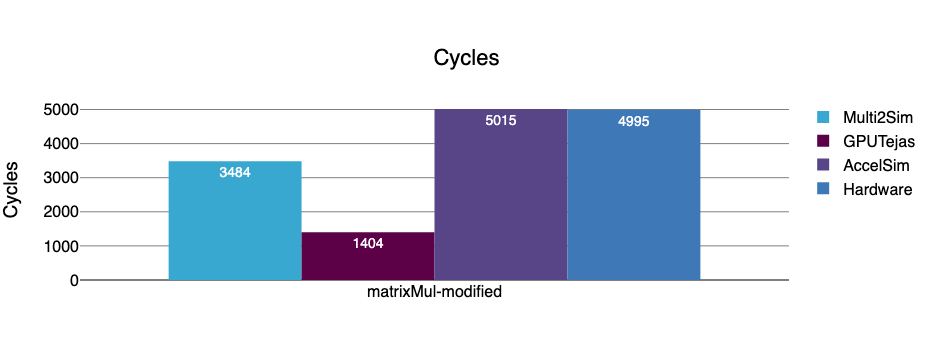

0    256.0
Name: l2_tex_read_transactions, dtype: float64
0.0


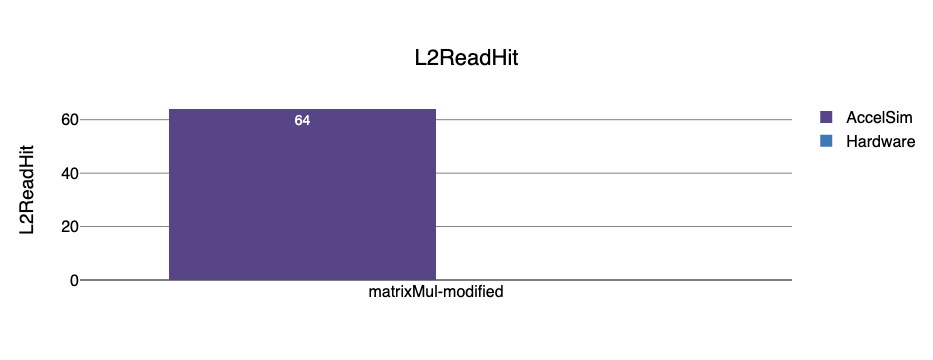

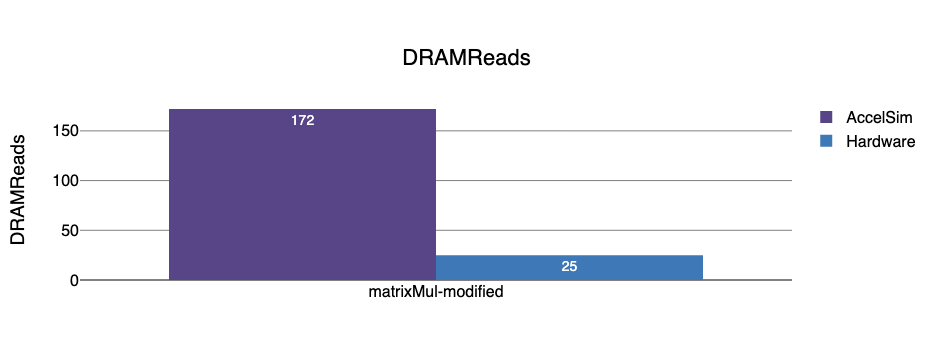

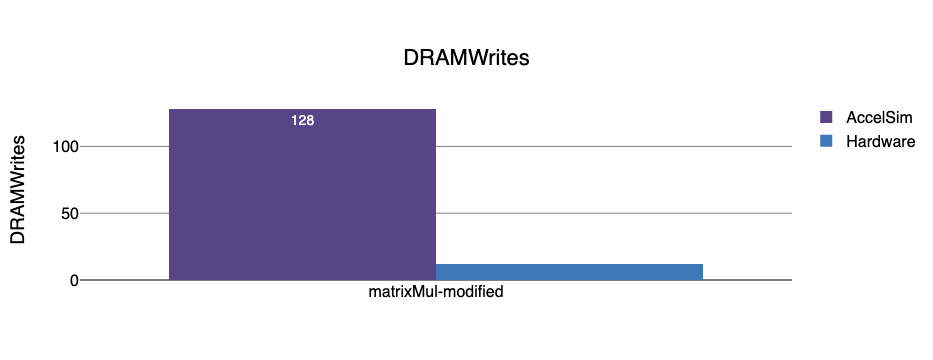

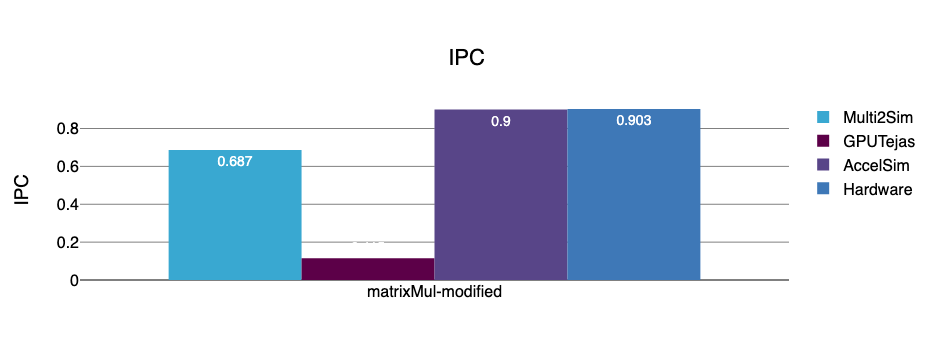

In [33]:
for metric_name, metric in metrics.items():
    bars = []
    # for i, (sim, cycles) in enumerate(data): # cycle_df.items():
    metric_df = metric.compute()
    for sim in metric_df.index: # cycle_df.items():
        # print(sim, cycles)
        bars.append(go.Bar(
            # x= [i],
            # y= [cycles],
            # x should be benchmarks
            x = [benchmark.name], # cycle_df.index,
            y = metric_df.loc[sim],
            text = metric_df.loc[sim],
            textposition='auto',
            textfont = dict(
                color="white",
                size=14,
            ),
            name=sim,
            # marker=go.bar.Marker(color=colors[i % len(colors)]),
            marker=dict(
                color=sim_color[sim],
                # color='rgba(50, 171, 96, 0.6)',
                line=dict(
                    color='rgba(50, 171, 96, 1.0)',
                    width=0
                ),
            ),
            # xaxis='x1',
        ))
    #if False:
    #    bars = []
    #    bars.append(go.Bar(
    #        # x= [i],
    #        # y= [cycles],
    #        x = metric_df.index, # ["Simulator"],
    #        y = metric_df["Cycles"],
    #        name=metric_name, # sim,
    #        # marker=go.bar.Marker(color=colors[i % len(colors)]),
    #        # xaxis='x1',
    #    ))

    layout = go.Layout(
        font_family="Helvetica",
        font_color="black",
        font_size=16,
        title=dict(
            text=metric_name,
            x=0.5,
            xanchor="center",
            yanchor="top",
        ),
        yaxis=go.layout.YAxis(
            title=metric_name,
            gridcolor="gray",
            zerolinecolor="gray",
            # range=[min_axis_val * 0.9 ,max_axis_val*1.1]
        ),
        barmode="group",
        bargroupgap=0,
        bargap=0.25,
        showlegend=True,
        plot_bgcolor="white",
    )
    fig = go.Figure(data=bars, layout=layout)
    # import plotly
    # plotly.offline.plot(fig, filename="./figs/bars.pdf", auto_open=False)
    fig.show()
    fig.write_image(f"./figs/bar_{metric_name}.pdf", format='pdf')

In [20]:
for metric_name, metric in metrics.items():
    metric_df = metric.compute()
    metric_df[metric_name] = metric_df["Value"]
    fig = px.bar(metric_df.reset_index(), x='Simulator', y=metric_name)
    # fig.show()

0    256.0
Name: l2_tex_read_transactions, dtype: float64
0.0


In [21]:
# plot type 2: bars: simulation time / execution time
# different layers
# single benchmark, single config

In [26]:
markers =[
    dict(size = 10, color = 'rgba(0, 0, 200, .5)'),
    dict(size = 10, color = 'rgba(0, 0, 0, .5)'),
    dict(size = 10, color = 'rgba(0, 182, 0, .4)'),
    dict(size = 10, color = 'rgba(0, 0, 193, .9)'),
    dict(size = 10, color = 'rgba(155, 155, 155, .9)'),
]
marker_sym = ['x', 'circle', 'circle', 'circle', 'circle']

# apps,appx,appy,avg_err,correl_co,num_over,num_under,num_less_than_one_percent,agg_err,rpd,nltenp,nmse
# we want avg_err,correl_co
# what is num_under, num_over, num_less_than_one_percent
# i guess also rpd,nltenp,nmse

def make_annotation(text, x, y):
    return go.layout.Annotation(
        text=text,
        xref='paper',  # use paper coordinates
        yref='paper',  # use paper coordinates
        x=x,           # position in norm. coord
        y=y,           # position in norm. coord  
        # font=Font(size=fontsize,color='Black'),  # text font size
        showarrow=False,
        bgcolor='#F5F3F2',
        bordercolor='#FFFFFF',
        borderwidth=1,
        borderpad=5,
    )

# correl_co = np.corrcoef(hw_array, sim_array)[0][1]
# avg_err = 0
# for err in errs:
#     avg_err += err
# avg_err = avg_err / len(errs)

# err = sim_array[-1] - hw_array[-1]
# if hw_array[-1] != 0:
#     # is that MAE?
#     err = (err / hw_array[-1]) * 100

# correl_co = np.corrcoef(hw_array, sim_array)[0][1]
# avg_err = 0
# for err in errs:
#     avg_err += err
# avg_err = avg_err / len(errs)

[4995. 3484. 4995. 1404. 4995. 5015.]


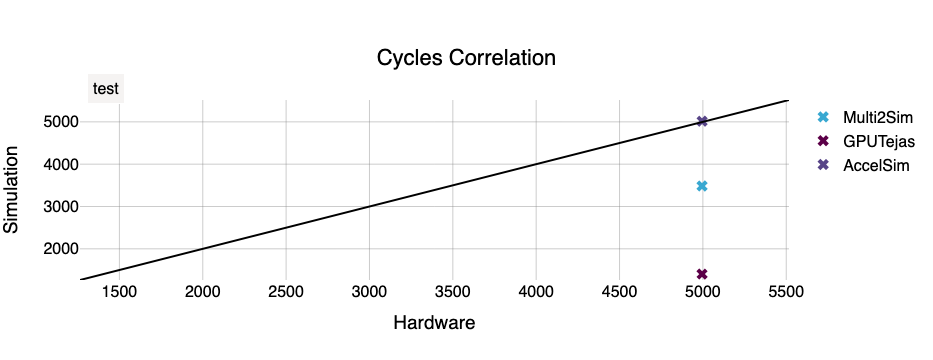

0    256.0
Name: l2_tex_read_transactions, dtype: float64
0.0
[ 0. 64.]


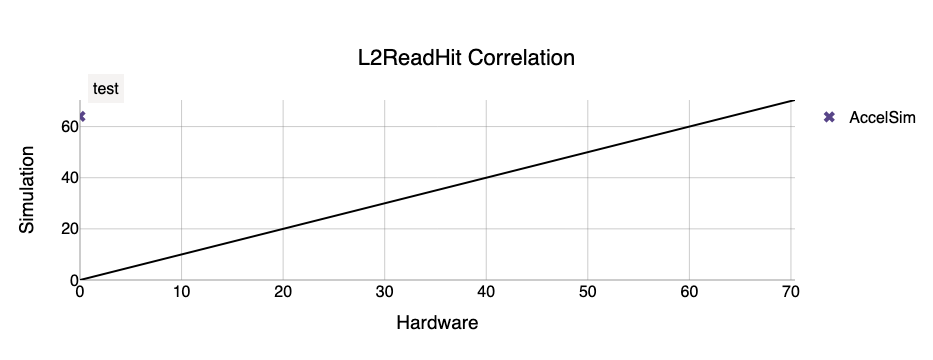

[ 25. 172.]


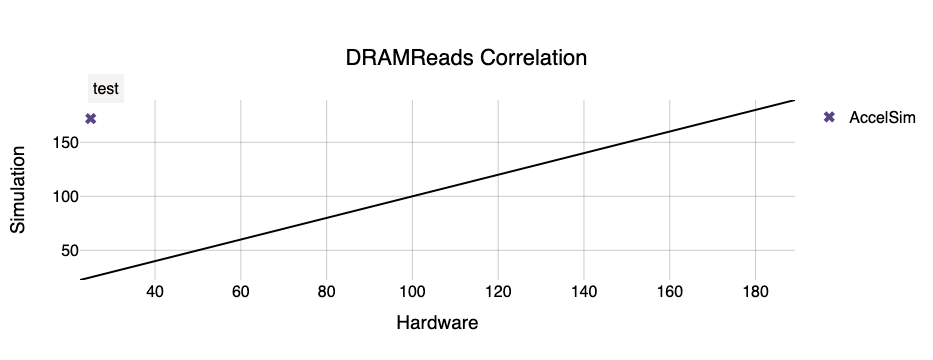

[ 12. 128.]


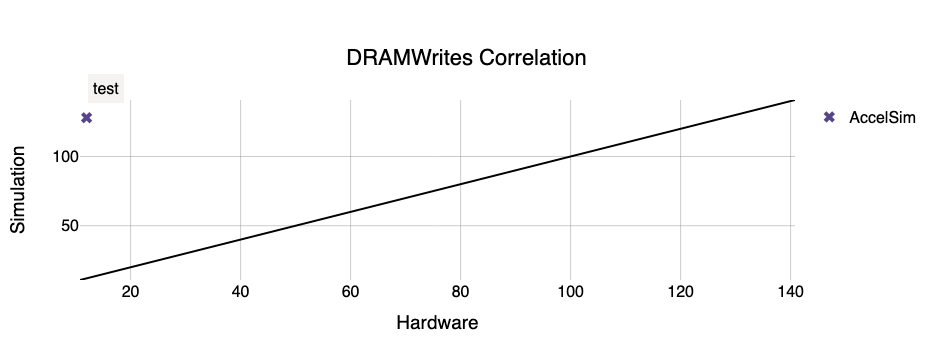

[0.903 0.687 0.903 0.115 0.903 0.9  ]


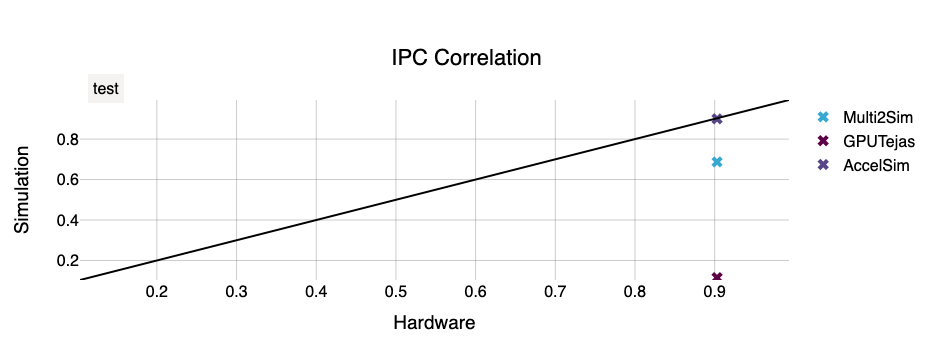

In [36]:
# plot type 3: scatter: cycles
# multiple benchmark (multiple inputs), single config
# using different colors for simulators and markers for benchmarks?

for metric_name, metric in metrics.items():
    metric_df = metric.compute()
    # hw_array = []
    # sim_array = []
    
    # max_axis_val = None
    # np.iinfo(np.int64).max
    # min_axis_val = None
    all_values = np.array([])

    traces = []
    for sim in metric_df.index:
        if sim == "Hardware":
            continue

        
        hw_array = metric_df.loc["Hardware"]
        sim_array = metric_df.loc[sim]
        # total_array = pd.concat([hw_array, sim_array])
        # total_array_max = total_array.max()
        # total_array_min = total_array.min()
        all_values = np.append(all_values, hw_array)
        all_values = np.append(all_values, sim_array)
        
        # if max_axis_val is None:
        #     max_axis_val = total_array_max
        # if 
        # max_axis_val = np.max(
        
        # max_axis_val
        # print(hw_array.to_numpy(), sim_array.to_numpy())

        if False:
            correl_co = np.corrcoef(hw_array.to_numpy(), sim_array.to_numpy())
            # [0][1]
            errs = sim_array - hw_array

            print("correl co", correl_co)
            print("errs", errs.mean())

        traces.append(go.Scatter(
            x = hw_array,
            y = sim_array,
            # x = cycle_df.loc["Hardware"],
            # y = cycle_df.loc[sim],
            hovertext = benchmark.name,
            # hover_data=['lifeExp', 'gdpPercap'],
            # x = cycle_df.index, # [benchmark.name], # cycle_df.index,
            # y = cycle_df["Cycles"], # .loc[sim].astype(int),
            mode = 'markers',
            marker = dict(
                size = 10,
                color = sim_color[sim],
                symbol = "x",
            ),
            # color = "red",
            # text=label_array,
            # error_x=dict(
            #    type='data',
            #    symmetric=False,
            #    array=hw_error,
            #    arrayminus=hw_error_min,
            #    visible=True
            #),
            name=sim,
        ))

    print(all_values)
    min_axis_val = np.min(all_values)
    max_axis_val = np.max(all_values)
    x_range = [min_axis_val * 0.9 ,max_axis_val*1.1]
    gridcolor = "rgba(128,128,128,.4)"
    # not used for now
    legend=dict(
        x=-.2,
        y=1.2,
        traceorder='normal',
        font=dict(
            family='Helvetica',
            size=20,
            color="black"
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    ),
    layout = go.Layout(
        title=dict(
            text=f"{metric_name} Correlation",
            x=0.5,
            xanchor="center",
            yanchor="top",
        ),
        font_family="Helvetica",
        font_color="black",
        font_size=16,
        xaxis=dict(
            title="Hardware",
            gridcolor=gridcolor,
            zerolinecolor=gridcolor,
            # type="log",
            range=x_range,
        ),
        yaxis=dict(
            title="Simulation",
            gridcolor=gridcolor,
            zerolinecolor=gridcolor,
            # type="log",
            range=x_range,
        ),
        annotations=[
            make_annotation("test", 0.01, 1.15),
        ],
        plot_bgcolor="white",
    )

    # todo: show confidence interval for the hardware measurements
    # maxe,mine = eval(correl.hw_error)
    # hw_error.append(maxe)
    # hw_error_min.append(mine)

    if False:
        # todo: update the axis values
        if hw_array[-1] > max_axis_val:
            max_axis_val = hw_array[-1]
        if sim_array[-1] > max_axis_val:
            max_axis_val = sim_array[-1]

        if hw_array[-1] < min_axis_val:
            min_axis_val = hw_array[-1]
        if sim_array[-1] < min_axis_val:
            min_axis_val = sim_array[-1]

    x_range = [layout.xaxis.range[0], layout.xaxis.range[1]]
    xyline = go.Scatter(
        x=x_range,
        y=x_range,
        showlegend=False,
        mode="lines",
        line=dict(
            # color='rgba(255,0,0,.7)',
            color="black",
        ),
    )


    traces.append(xyline)
    #xyline.line.color = 'rgba(255,0,0,.7)'
    #kernel_data.append(xyline)

    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    fig.write_image(f"./figs/scatter_{metric_name}.pdf", format='pdf')

In [32]:
if False:
    if not options.err_off:
        anno = cfg + " ({0} apps, {1} kernels ({6} < 1% Err, {4} under, {5} over)) [Correl={2:.4} Err={3:.2f}%]"\
            .format(appcount, kernelcount,correl_co, avg_err,num_under,num_over,num_less_than_one_percent, num_less_than_ten_percent)
    else:
        anno = cfg + " ({0} apps, {1} kernels ({6} < 1% Err, {4} under, {5} over)) [Correl={2:.4}]"\
            .format(appcount, kernelcount,correl_co, avg_err,num_under,num_over,num_less_than_one_percent, num_less_than_ten_percent)


# this is just for inspiration
if len(traces) == len(renames):
            trace.name = renames[count]
        if count < len(marker_order) and marker_order[0] != "":
            trace.marker = markers[int(marker_order[count])]
            trace.marker.symbol = marker_sym[int(marker_order[count])]
        else:
            trace.marker = markers[count %len(markers)]
            trace.marker.symbol = marker_sym[count %len(markers)]
        trace.mode = "markers"
        trace.error_x.color = trace.marker.color
        
        # Set the alpha on the error bars to be 30%
        trace.error_x.color =  re.sub(r"(,.*,.*),.*\)",r"\1,0.3)", trace.error_x.color)
        kernel_annotations.append(make_anno1(anno,22,0,1.115 - count * 0.05))
        print_anno += anno + " :: {0} high error points dropped from Err calc. {1} dropped for HW too low (>{2})\n".format(
            err_dropped, hw_low_drop, correlmap.drophwnumbelow)
        agg_cfg += "." + cfg
        app_str, kernel_str = make_pretty_app_list(apps_included)
        kernellist_file_contents += "{0}\n{1}\n\n".format(anno, kernel_str)
        kernel_csv_file_contents += "{0}\n\n"\
            .format(getCorrelCsvRaw(anno, trace.text, trace.x, trace.y))

        apps,appx,appy,avg_err,correl_co,num_over,num_under,num_less_than_one_percent,agg_err,rpd,nltenp,nmse \
            = getAppData(trace.text, trace.x, trace.y,layout.xaxis.title, correlmap)

        app_max = max ( app_max, max(appx), max(appy) )
        app_min = min ( app_min, min(appx), min(appy) )

        app_csv_file_contents += "{0}\n\n"\
            .format(getCorrelCsvRaw( anno, apps,appx,appy ))
        kernel_data.append(trace)

        app_anno = cfg + " ({0} apps ({5} < 1% Err, {3} under, {4} over, {8} < 10% Err)) [Correl={1:.4} Err={2:.2f}% Agg_Err={6:.2f}% RPD={7:.2f}%,NMSE={9:.2f}]"\
            .format(len(apps), correl_co, avg_err,num_under,num_over,num_less_than_one_percent,agg_err,rpd,nltenp,nmse)
        applist_file_contents += "{0}\n{1}\n\n".format(app_anno, app_str)
        applist_file_contents += "apps:\n{0}\n\n".format(apps)
        app_annotations.append(make_anno1(app_anno,22,0,1.115 - count * 0.05))
        print_anno += "Per-App :: " + app_anno + "\n"

        if "Cycles" in layout.xaxis.title.text or "IPC" in layout.xaxis.title.text or "Instructions" in layout.xaxis.title.text:
            name_text = "<b>" + trace.name + " [Correl={0:.2} MAE={1:.0f}%]</b>".format(correl_co, avg_err, nmse)
        else:
            name_text = "<b>" + trace.name + " [Correl={0:.2} NRMSE={1:.2f}]</b>".format(correl_co, nmse)

        app_trace = go.Scatter(
            x = appx,
            y = appy,
            mode = 'markers',
            text=apps,
            marker = trace.marker,
            name=name_text,
        )
        app_data.append(app_trace)
        count += 1

    if not plot_correl_options.noanno:
        layout.annotations=kernel_annotations
    if plot_correl_options.plotname == "":
        plotname = plotfile + agg_cfg
    else:
        plotname = plotfile + "." + plot_correl_options.plotname

    plotname = os.path.join(outdir, plotname)[:200]

    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    f = open(plotname + ".apps.txt", 'w')
    f.write(applist_file_contents)
    f.close()
    f = open(plotname + ".kernel.txt", 'w')
    f.write(kernellist_file_contents)
    f.close()
    f = open(plotname + ".kernel.raw.csv", 'w')
    f.write(kernel_csv_file_contents)
    f.close()
    f = open(plotname + ".app.raw.csv", 'w')
    f.write(app_csv_file_contents)
    f.close()

    print("Plotting {0} : [{1}]\n{2}"\
        .format(hw_cfg, layout.title.text, print_anno))

    png_layout = copy.deepcopy(layout)
    png_layout.title=None
#    for anno in png_layout.annotations:
#        anno.font= Font(size=22,color='black')
    png_layout.xaxis.titlefont.size = font_size
    png_layout.xaxis.titlefont.color='black'
    png_layout.xaxis.tickfont.size=tick_font_size
    png_layout.xaxis.tickfont.color='black'
    png_layout.xaxis.type=correlmap.plottype
    png_layout.xaxis.autorange=True

    png_layout.yaxis.titlefont.size = font_size
    png_layout.yaxis.tickfont.size = tick_font_size
    png_layout.yaxis.titlefont.color='black'
    png_layout.yaxis.tickfont.color='black'
    png_layout.yaxis.type=correlmap.plottype
    png_layout.yaxis.autorange=True

    png_layout.margin.t = 100

    png_layout.legend=dict(
        x=-.2,
        y=1.2,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=font_size,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
   )
    xyline = go.Scatter(x=[layout.xaxis.range[0] + 1, layout.xaxis.range[1]],
        y=[layout.xaxis.range[0] + 1,layout.xaxis.range[1]],showlegend=False,mode="lines")
    xyline.line.color = 'rgba(255,0,0,.7)'
    kernel_data.append(xyline)

    if "linear" == correlmap.plottype:
        app_min = -5
        legypos = float(plot_correl_options.legend)*.95
        legxpos = -.25
        axisrange=[app_min*.95, app_max*1.05]
    else:
        legypos = float(plot_correl_options.legend)
        legxpos = -.35
        if app_min == 0:
            rmin = np.log10(0.9)
        else:
            rmin = np.log10(app_min)*.98
        if app_max == 0:
            rmax = 0
        else:
            rmax = np.log10(app_max)*1.02
        axisrange=[rmin, rmax]

    app_layout = go.Layout(
        title="Per App " + layout.title.text,
        xaxis=dict(
            title=layout.xaxis.title,
            range=axisrange,
            gridcolor="rgba(128,128,128,.4)",
            zerolinecolor="rgba(128,128,128,.4)"
        ),
        yaxis=dict(
            title=layout.yaxis.title,
            range=axisrange,
            gridcolor="rgba(128,128,128,.4)",
            zerolinecolor="rgba(128,128,128,.4)"
        ),
        legend=dict(
            x=legxpos,
            y=legypos,
            traceorder='normal',
            font=dict(
                family='sans-serif',
                size=font_size,
                color='#000'
            ),
            bgcolor='rgba(255,255,255,0.0)',
            bordercolor='rgba(255,255,255,0.0)',
            borderwidth=2
        ),
        plot_bgcolor='#FFFFFF',
        # autosize=False,
        # width=2000,
        # height=2000,
   )

    app_layout.title=None
    app_layout.xaxis.titlefont.size = font_size
    app_layout.xaxis.titlefont.color='black'
    app_layout.xaxis.tickfont.size=tick_font_size
    app_layout.xaxis.tickfont.color='black'
    app_layout.xaxis.type=correlmap.plottype
#    app_layout.xaxis.autorange=True

    app_layout.yaxis.titlefont.size = font_size
    app_layout.yaxis.tickfont.size = tick_font_size
    app_layout.yaxis.titlefont.color='black'
    app_layout.yaxis.tickfont.color='black'
    app_layout.yaxis.type=correlmap.plottype
#    app_layout.yaxis.autorange=True

    if not plot_correl_options.noanno:
        app_layout.annotations=app_annotations
    app_xyline = go.Scatter(
        x=[app_min + 1,
            app_max],
        y=[app_min + 1,
            app_max],
            showlegend=False,mode="lines")
    app_xyline.line.color = xyline.line.color
    app_data.append(app_xyline)
    # plotly will only let you do .pdf if you pay for it - I have.
    # To get this to work for free change the extension to .png
    if image_type != "":
#        png_name = plotname.replace(".", "_") + "." + image_type
#        Figure(data=kernel_data,layout=png_layout).write_image(png_name, height=512.0*1.05, width=512)

        png_name = plotname.replace(".", "_") + ".per-app." + image_type
        go.Figure(data=app_data,layout=app_layout).write_image(
            png_name,
            height=height,
            width=width,
            # height=512.0*1.05,
            # width=512,
        )


    # This generates the html
    plotly.offline.plot(go.Figure(data=kernel_data,layout=png_layout), \
        filename= plotname + ".per-kernel.html", auto_open=False)

    plotly.offline.plot(go.Figure(data=app_data,layout=app_layout), \
        filename= plotname + ".per-app.html", auto_open=False)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 13)

In [ ]:
legend=dict(
            x=0,
            y=0,
            traceorder="reversed",
            title_font_family="Times New Roman",
            font=dict(
                family="Courier",
                size=16,
                color="black"
            ),
            bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=2
        )

In [ ]:
colors= ['#0F8C79','#BD2D28','#E3BA22','#E6842A','#137B80','#8E6C8A','#9A3E25', '#E6842A']
stat_count = 0
for stat,value in all_stats.items():
    traces = []
    cfg_count = 0
    apps, data = value
    for k,v in data.items():
        traces.append(Bar(
            x= apps,
            y= v,
            name=k,
            marker=Marker(color=colors[cfg_count % len(colors)]),
            xaxis='x1',
            )
        )
        cfg_count += 1

    data = Data(traces)
    layout = Layout(
        title=stat,
        barmode='group',
        bargroupgap=0,
        bargap=0.25,
        showlegend=True,
        yaxis=YAxis(
            title=stat,
        )
    )
    fig = Figure(data=data, layout=layout)
    figure_name = re.sub('[^0-9a-zA-Z]+','_',stat) + "_" + options.plotname
    print("plotting: " + figure_name)
    outdir = (os.path.join(this_directory,"htmls"))
    if not os.path.exists( outdir ):
        os.makedirs(outdir)
    plotly.offline.plot(fig, filename=os.path.join(outdir,figure_name + ".html"),auto_open=False)
    stat_count += 1

In [74]:
bench_config = bench_cls(
    run_dir=sim_run_dir,
    benchmark=bench,
    config=conf,
)

NameError: name 'bench_cls' is not defined

In [22]:
for c, b in list(itertools.product(config, benchmark)):
    if simulator == "native":
        conf = Config(name=c.lower(), path=None)
    else:
        conf = configs.get(c.lower())

NameError: name 'itertools' is not defined

In [ ]:
sim_run_dir = Path(run_dir) / simulator.lower()